# ML Model Diagnosis

In this lab you will implement the training set size experiment described in class, and also explore transfer learning using a pre-trained convolutional neural network (CNN) for image classification.

We will use the [Intel Image Classification dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification).  Download it from Kaggle or from [OneDrive](https://cpslo-my.sharepoint.com/:u:/g/personal/jventu09_calpoly_edu/EW40XA_u31RNil1YzmBX-GUBSsqjb508K-iBA2ka5Uri_A?e=webnMY).

In [2]:
import glob
import imageio
import skimage
from matplotlib import pyplot as plt
import numpy as np
import tensorflow
import keras
import sklearn
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split


2024-10-23 15:39:18.696723: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 15:39:18.708007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 15:39:18.722996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 15:39:18.727410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 15:39:18.738826: I tensorflow/core/platform/cpu_feature_guar

Here is some code to load the dataset.

In [3]:
label_names = ['buildings','forest','glacier','mountain','sea','street']

In [4]:
def load_split(split):
    images = []
    labels = []
    for label in label_names:
        image_paths = sorted(glob.glob(f'archive/seg_{split}/seg_{split}/{label}/*.jpg'))
        for path in image_paths:
            image = imageio.imread(path)
            if len(image.shape)<3:
                continue
            if image.shape[0]!=150 or image.shape[1]!=150 or image.shape[2]!=3:
                continue
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_split('train')
test_images, test_labels = load_split('test')

print(len(train_images))

/tmp/ipykernel_27630/3586013888.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path)


13986


Text(0.5, 1.0, 'buildings')

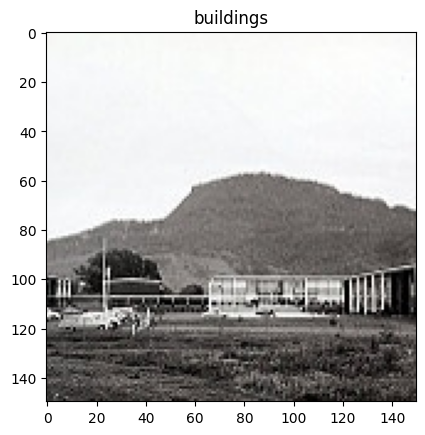

In [5]:
plt.imshow(train_images[0])
plt.title(train_labels[0])

This time we will randomly shuffle the training set, to support our later experiments.

In [6]:
inds = list(range(len(train_images)))
np.random.shuffle(inds)
train_images = train_images[inds]
train_labels = train_labels[inds]

Now we have arrays `train_images` and `train_labels` containing the images and labels for the training set, and the same for the test set.

Here we create a [MobileNetV2](https://arxiv.org/abs/1801.04381) model and download its pre-trained weights.  MobileNetV2 is a lightweight but high-performing CNN.  You can read about other Keras pre-trained models [here](https://keras.io/api/applications/).

The ```include_top=False``` argument tells Keras that we don't want the part of the network that is for 1000-class classification using the ImageNet labels.  Instead we take only the part of the network that computes a descriptor for the image (sometimes called an "embedding" or "latent vector" in the ML community).

We have the ```pooling='avg'``` argument because otherwise the network outputs a small grid of descriptors, so we are instead asking it to compute the average descriptor over the grid.

In [7]:
mobilenet = keras.applications.MobileNetV2(include_top=False,pooling='avg')

/tmp/ipykernel_27630/568530069.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = keras.applications.MobileNetV2(include_top=False,pooling='avg')


1. Compute a MobileNetV2 descriptor for each image to make two lists, `train_descriptors` and `test_descriptors`.

Use ```mobilenet.predict(...,verbose=True)``` to run the network on the images and produce descriptors.

In [8]:
train_descriptors = mobilenet.predict(train_images, verbose = True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 73s 164ms/step


In [9]:
test_descriptors = mobilenet.predict(test_images, verbose = True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step


2. Build a k-nearest neighbors classifier on the training set (```sklearn.neighbors.KNeighborsClassifier```).

This model will find the $k$ nearest neighbors to the query point and output the most common label.  Use $k=10$.

Run the model on the training and testing sets and print out the accuracy score for each (```sklearn.metrics.accuracy_score``` or simply use ```model.score```).

In [10]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(train_descriptors, train_labels)
predicted_labels = knn.predict(test_descriptors)

accuracy = sklearn.metrics.accuracy_score(test_labels, predicted_labels)


In [11]:
print(accuracy)

0.7009689274974942


3. Now let's explore how train and test accuracy change as training set size increases.

We will test a range of training set sizes in increments of 1000 (so 1000, 2000, 3000, ... up to the original size of the training set).

For each size setting $s$, fit a ```kNeighborsClassifer``` model to the first $s$ examples in the training set.   Use $k=10$.

Then compute the accuracy of the model on the chosen subset of the training set, and the entire test set.  *Note: always use the entire test set!*


Make a plot of the two accuracy values as the training set size increases.  Put both lines on the same plot.

In [43]:
n_train_samples = len(train_descriptors)
n_test_samples = len(test_descriptors)
print(n_train_samples)
training_accuracy_list = []
test_accuracy_list = []

step = 1000
for s in range(1000, n_train_samples + step, step):  
    s = min(s, n_train_samples)  

    knn = KNeighborsClassifier(n_neighbors=10)
    
    knn.fit(train_descriptors[:s], train_labels[:s])
    
    train_predicted_labels = knn.predict(train_descriptors[:s])
    train_accuracy = sklearn.metrics.accuracy_score(train_labels[:s], train_predicted_labels)
    
    test_predicted_labels = knn.predict(test_descriptors)
    test_accuracy = sklearn.metrics.accuracy_score(test_labels, test_predicted_labels)

    # Append the accuracies to the lists
    training_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)


13986


14


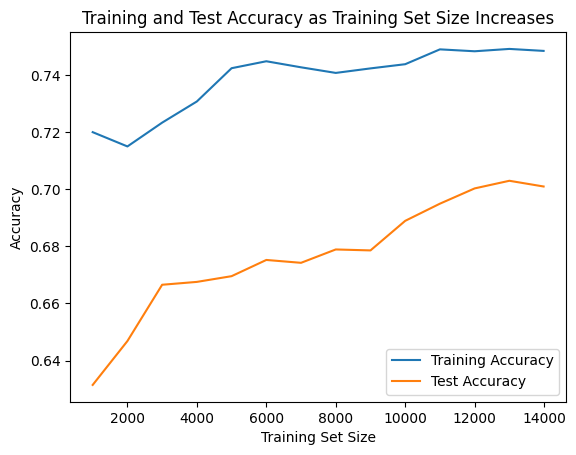

In [45]:
print(len(training_accuracy_list))

x_axis=[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000, 11000, 12000, 13000, 13986]
plt.plot(x_axis, training_accuracy_list, label='Training Accuracy')  # Plot training accuracy
plt.plot(x_axis, test_accuracy_list, label='Test Accuracy')      # Plot test accuracy

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy as Training Set Size Increases')

plt.legend()

# Show the plot
plt.show()

Analyze the results.  If we want to improve the model's test set accuracy, what should we do -- add more training data, or choose a different model?

Both training/test accuracy are trending upwards, there is an issue with variance. However, because both of them are trending upwards, I think adding more training data is a better approach then choosing a new model. The training accuracy is low, so I am not worried at this stage about overfitting (when introducing more data)